<a href="https://colab.research.google.com/github/yuki-tamaribuchi/ml_code_kata/blob/master/recognize_digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.pyimagesearch.com/2017/02/13/recognizing-digits-with-opencv-and-python/#pyi-pyimagesearch-plus-optin-modal

In [1]:
!wget https://i.redd.it/m84cd3haccay.jpg

--2021-02-17 11:50:03--  https://i.redd.it/m84cd3haccay.jpg
Resolving i.redd.it (i.redd.it)... 151.101.1.140, 151.101.65.140, 151.101.129.140, ...
Connecting to i.redd.it (i.redd.it)|151.101.1.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30522 (30K) [image/jpeg]
Saving to: ‘m84cd3haccay.jpg.2’

m84cd3haccay.jpg.2  100%[===================>]  29.81K  --.-KB/s    in 0.002s  

2021-02-17 11:50:03 (12.8 MB/s) - ‘m84cd3haccay.jpg.2’ saved [30522/30522]



In [2]:
from imutils.perspective import four_point_transform
from imutils import contours
import imutils
import cv2

In [3]:
DIGITS_LOOKUP = {
	(1, 1, 1, 0, 1, 1, 1): 0,
	(0, 0, 1, 0, 0, 1, 0): 1,
	(1, 0, 1, 1, 1, 1, 0): 2,
	(1, 0, 1, 1, 0, 1, 1): 3,
	(0, 1, 1, 1, 0, 1, 0): 4,
	(1, 1, 0, 1, 0, 1, 1): 5,
	(1, 1, 0, 1, 1, 1, 1): 6,
	(1, 0, 1, 0, 0, 1, 0): 7,
	(1, 1, 1, 1, 1, 1, 1): 8,
	(1, 1, 1, 1, 0, 1, 1): 9
}

In [4]:
image=cv2.imread('m84cd3haccay.jpg')

#リサイズ
image=imutils.resize(image,height=500)

#グレイスケール化
gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

#ガウスぼかし
#Applying Gaussian blurring with a 5×5 kernel to reduce high-frequency noise.
blurred=cv2.GaussianBlur(gray,(5,5),0)

#エッジ検出
edged=cv2.Canny(blurred,50,200,255)

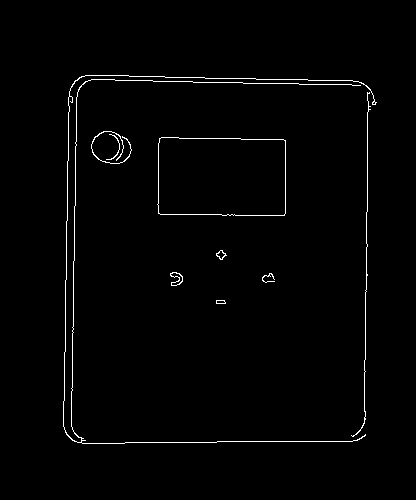

In [5]:
from google.colab.patches import cv2_imshow
cv2_imshow(edged)

In [6]:
#輪郭取得
#https://pystyle.info/opencv-find-contours/
'''
mode引数は輪郭を検索する方法を指定
    cv2.RETR_EXTERNAL: 一番外側の輪郭のみ抽出する
    cv2.RETR_LIST: すべての輪郭を抽出するが、階層構造は作成しない
    cv2.RETR_CCOMP: すべての輪郭を抽出し、2階層の階層構造を作成する
    cv2.RETR_TREE: すべての輪郭を抽出し、ツリーで階層構造を作成する


method引数は輪郭点の近似手法を指定
cv2.CHAIN_APPROX_SIMPLEを選ぶ場合が多い
'''
cnts=cv2.findContours(edged.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts=imutils.grab_contours(cnts)

#ソート
cnts=sorted(cnts,key=cv2.contourArea,reverse=True)

In [7]:
displayCnt=None
for c in cnts:
  peri=cv2.arcLength(c,True)
  approx=cv2.approxPolyDP(c,0.02*peri,True)

  if len(approx)==4:
    displayCnt=approx
    break

In [8]:
displayCnt

array([[[159, 138]],

       [[158, 213]],

       [[284, 215]],

       [[285, 140]]], dtype=int32)

In [9]:
wraped=four_point_transform(gray,displayCnt.reshape(4,2))
output = four_point_transform(image, displayCnt.reshape(4, 2))

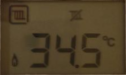

In [10]:
cv2_imshow(output)

In [11]:
thresh=cv2.threshold(wraped,0,255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(1,5))
thresh=cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel)

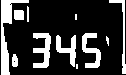

In [12]:
cv2_imshow(thresh)

In [13]:
cnts=cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts=imutils.grab_contours(cnts)
digitCnts=[]

for c in cnts:
  (x,y,w,h)=cv2.boundingRect(c)

  if w >=15 and (h>=30 and h<=40):
    digitCnts.append(c)

In [14]:
digitCnts=contours.sort_contours(digitCnts,method='left-to-right')[0]
digits=[]

In [15]:
for c in digitCnts:
  (x,y,w,h)=cv2.boundingRect(c)
  roi=thresh[y:y+h,x:x+w]

  (roiH,roiW)=roi.shape
  (dW,dH)=(int(roiW*0.25),int(roiH*0.15))
  dHC=int(roiH*0.05)

  segments=[
            ((0, 0), (w, dH)),
            ((0, 0), (dW, h // 2)),
		        ((w - dW, 0), (w, h // 2)),
		        ((0, (h // 2) - dHC) , (w, (h // 2) + dHC)),
		        ((0, h // 2), (dW, h)),
		        ((w - dW, h // 2), (w, h)),
		        ((0, h - dH), (w, h))
  ]

  on=[0]*len(segments)

In [16]:
for (i,((xA,yA),(xB,yB))) in enumerate(segments):
  segROI=roi[yA:yB,xA:xB]
  total=cv2.countNonZero(segROI)
  area=(xB-xA)*(yB-yA)

  if total/float(area)>0.5:
    on[i]=1

digit = DIGITS_LOOKUP[tuple(on)]
digits.append(digit)
cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 1)
cv2.putText(output, str(digit), (x - 10, y - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 255, 0), 2)

array([[[ 51,  65,  83],
        [ 17,  31,  49],
        [ 18,  32,  50],
        ...,
        [ 14,  33,  50],
        [ 19,  39,  57],
        [ 55,  76,  94]],

       [[ 47,  61,  79],
        [ 16,  30,  48],
        [ 15,  29,  47],
        ...,
        [ 14,  34,  50],
        [ 13,  33,  50],
        [ 53,  74,  92]],

       [[ 48,  62,  80],
        [ 21,  35,  53],
        [ 19,  33,  51],
        ...,
        [ 19,  39,  54],
        [ 17,  37,  53],
        [ 56,  76,  94]],

       ...,

       [[ 44,  60,  77],
        [ 28,  44,  61],
        [ 29,  45,  62],
        ...,
        [ 29,  50,  65],
        [ 24,  45,  60],
        [ 29,  49,  65]],

       [[ 43,  59,  76],
        [ 27,  43,  60],
        [ 29,  45,  62],
        ...,
        [ 26,  47,  62],
        [ 21,  42,  57],
        [ 31,  51,  67]],

       [[ 45,  61,  78],
        [ 30,  46,  63],
        [ 29,  45,  62],
        ...,
        [ 56,  77,  92],
        [ 56,  77,  92],
        [ 65,  85, 101]]

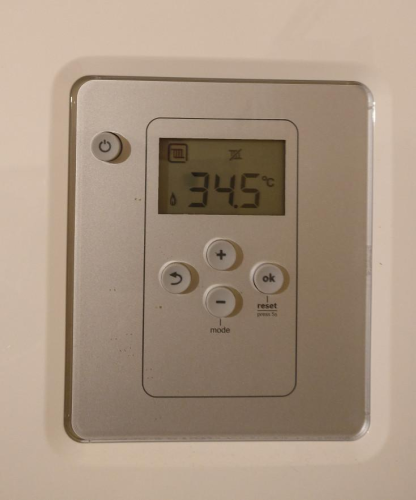

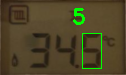

In [17]:
cv2_imshow(image)
cv2_imshow(output)